In [1]:
# Installing and importing the essential libraries

!pip install fuzzywuzzy 
from fuzzywuzzy import process 
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import random

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Accessing the data files from Google Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This txt file consists of the Song ID of all the songs in the dataset mapped to its corrsponding Song Title

song_id_song_title = pd.read_csv('/content/drive/MyDrive/ML Project k_NN/unique_tracks.txt', sep='<SEP>', header=None)
song_id_song_title.columns = ['track_id', 'song_id', 'artist_name', 'song_title']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# Making a dictonary that maps Song ID to Song Title

song_id_to_title = {}

for index, row in song_id_song_title.iterrows():
  song_id_to_title[row['song_id']] = row['song_title']

In [5]:
# This txt file consisits the data of the number of times a particular user has listened to a particular song 

user_song_count = pd.read_csv('/content/drive/MyDrive/ML Project k_NN/year1_test_triplets_visible.txt', sep='\t', header=None)
user_song_count.columns = ['user_id', 'song_id', 'listen_count'] # Assigning column names to access columns efficiently

# This txt file consists of the Song ID of all the songs in the dataset
song_unique =  pd.read_csv('/content/drive/MyDrive/ML Project k_NN/kaggle_songs.txt' , sep='\t', header=None)
song_unique.columns = ['song_id']

# Now we merge the 2 datasets to form a merged dataset 
songs = pd.merge(user_song_count, song_unique, on="song_id", how="left")
songs_df = pd.DataFrame(songs)

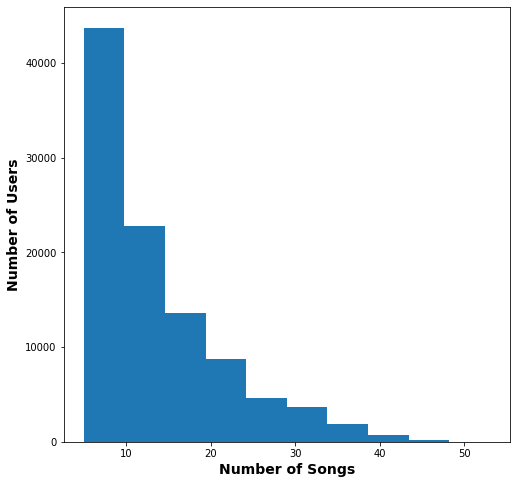

In [6]:
# Visualising the number of songs a particular user has listened to
user_count_song = songs_df.groupby('user_id')['song_id'].count()

plt.figure(figsize = (8, 8))
plt.xlabel('Number of Songs', fontsize = 14, fontweight = 'bold')
plt.ylabel('Number of Users', fontsize = 14, fontweight = 'bold')
plt.hist(user_count_song)
plt.show()

In [7]:
# Since a lot of users have listened very few songs and due to conputational constraints, we only consider those users who have listened to atleast 30 songs
user_filtered = user_count_song[user_count_song > 30].index.to_list()

df_user_filtered = songs[songs['user_id'].isin(user_filtered)].reset_index(drop=True)

# Converting the dataset to pivot table
pivot_data = df_user_filtered.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)
pivot_data.head() # Visualising the pivot table 

user_id,00020fcd8b01986a6a85b896ccde6c49f35142ad,000a43eb37163bb2f93020e107a2d543f27257b7,000ae9c80733348ff64cd3716a27477b94578d9d,001599607ba12f1aa6d6ffe3237e00c4dda0055c,0029bec66fe7ce2a396c2f78b35aedcd2b9d3e4a,003032fc00365d6f15f047c63717a14e0d8aced7,00387504e8fc8aa34827a637dea25000e86e85a3,0041d170b100df47f77dd1799e7fcffaeb06ee5a,0051b37d4665b4e6e2e1f048b671c19618c0a931,005c6f0d9f7051ea7ca3009d2075cd81293c03c5,006d3c79b9ed677280f8ddbc422d7b0fedd6d1fa,006f3e24c7299184ac3608b0fc439146ca8cd174,007e450faa8daa47362a2a3f5d0a6f4ecd535f3f,0093ea2ad5eebbfe7635a70909b7988d1b340a5a,00949b7e0d675efa40992a0e3f66db26b7a27b08,009fa39e4672f0c03ca89b1cef8c3c667d2a340f,00a985e7eac5c957d94ce2b92cb24d61ca0a51c3,00b6e2d64c7706188507e5433950bcf957acdfb8,00b96e1873307f6f9dee336a169abbdd023f3f46,00d658d58eb6307ad01643574b311da88f85c836,00e87f46ef29a603a8a5005b96252408bb3c8106,00e894fb85525341a9749ba79f3fa93914e45558,01047b99e00bb0743f66bb321bdd62e38fddb0a5,01164315e8720e42607d26437ed7dea32bf3f102,01284eec22faa0dc995d3c35d57d2b8d495ed306,0132fa7069e4518094dbce9efc84376a6de8a680,01336509e904660c1093e188777284194f19aba1,0138b1842d6e47baf4b789b4ea8fe461fc5ee869,013e798510337164b03d7f91aeb97c21fb26385a,015b644780ebba0b20a041b864ad799692e976e6,015deb96150a3c2f90f3e321e16c547a4f174391,0161905dd597c127422558f58ecfa50f687710b2,016a24e91a72c159a5048ab1b9b2ba5ce761b526,016e99aa88d75f6d0a6cafeb40000740152be611,0173a151849cb633441300c82ab606b778732f67,018f3b68d8d8f99dc94b4e5018d7dc3ccba2c01e,019155ada2fc5ef146e6b10078b66e33e7d88678,01a85f046df67f633f93584e4304c2ba9ed69717,01bfad1ec3298a476f9148a86c7ed315b642a7df,01d0d50b2be6d5a47e5da80ad9cf1f4e24ec4f99,...,fed5a9b83d0ee5e27280e7abc84651d227773f63,fee130e890ada13c2fde11719ad07003a161400b,feeedab95c329534fa254a5274a1f44ef3dcc13f,fef5edae636b34b85358855bdc6e64b9dba62b3a,fef8089a805b79f8f4fb7f3914998c2f1c488d81,ff125cc7b865c5be00d6a1d2a4e0984278cdddc4,ff208143ec040f14f179f963c284a4a3f8ce1d65,ff277d211dcd9f3d34e727add2f4aa6033313bc6,ff2ae49d4a4004ac849e9314cde42bb1bac4278d,ff30c9ddaf0fd5f83b01f2e903fc14d3f7b99099,ff3667dfb5583ce10c73e41fa92879a0533d4207,ff3af695709783f8242105de952741d55f3970df,ff3e2ac07a6457ebfd11b7aaef61064106a0042b,ff3eec3a6070570dee7367671732501b2647db81,ff511fa7338117958042d2a698513697a736bc8e,ff6197b442d8d9208ac329c53c8a2e21a0e82670,ff63ab995d2d5b87ced0f93dc3b4d13db02c2491,ff6410212c75d9928b0db7c3f0a657fcf7ad8ab5,ff652a131adaef07d9c1dd26142092dd7cb1267d,ff6c29c1f4a3b571b0acbefaafe46285f511b0f0,ff6e265e162823e3830b0ff52ea49aa861864853,ff70c156965a192f7009484f2de6b9017b1e9344,ff719a2081596255b147a26a26c90bcc8493c3cf,ff77fea5a8d84f5109de17185e2a7fb5d7e2a467,ff80830a101547b5c112e72e939dde33f0a68a1b,ff812496e5c72aa3bc5a507afd8b7ea955b1f111,ff8a343fa2e3b0f61f3728dec69eae6ad137528d,ff8ce72b292d55f6c3baffe0a90b0193dec458f9,ff8e4bd0e848f80a47a3988eb853e81d0cdb5a23,ff98f8739d8305a32f14b366e49efab101e4da87,ffa5d7f5673b22ab0fa73d44e0ea4a44fa64bdd9,ffb1f643e98e56b1ab6b38273e6173ae6faef2f8,ffb31b33a094c7392d4db327c222e531d2a46d46,ffca0a403073333b577968ccc71b4269da6f07e9,ffda55050d450037e24b67b8e0f48f4f16a03872,ffe96e24a565e460bac7f144a99b21e6b3ec421d,ffec588ea1dbc63bbd28f2155a10e03c020468a6,ffee916020d891a74264b8326829742333b79103,ffef5c05e4f25af2e8e9880af84d66936056b597,fffd0a1b26c37a55574d844277d176991d054f99
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAABCT12AB0185A57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [30]:
# Creating a mapping from row index to row name (i.e song name) 

row_index = pivot_data.index
row_index = list(row_index)

song_id_to_idx = {}

for i in range(len(row_index)):
  song_id_to_idx[row_index[i]] = i

In [9]:
# Since we could clearly see that the pivot table has many 0-entries it would be difficult to perform operations on such a large dataset
# Hence we convert the pivot table to sparse matrix

sparse_matrix = csr_matrix(pivot_data.values)

In [10]:
# Fitting the sklearn's "NearestNeighbors" model on our dataset

model = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20)
model.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [11]:
# Song Recommendation based on random choosing of song
# User can input song name, and 'process.extractOne' method could be used for finding the index of the song name entered from the dataset
# This method however requires computational resources not available with us currently  

song_index = random.randint(0, len(row_index) - 1)
print('Songs related to: `' + str(song_id_to_title[row_index[song_index]]) + '` are getting recommended..........')
print('====================================================================')
distance, indices = model.kneighbors(sparse_matrix[song_index], n_neighbors=10) # Suggesting the 10 nearest songs to a particular song listened by the user
for i in range(len(indices[0])):
  if indices[0][i] != song_index:
    print('Song Title: `' + song_id_to_title[str(row_index[indices[0][i]])] + '` which is at a cosine distance of ' + str(distance[0][i]) + ' from `' + str(song_id_to_title[row_index[song_index]]) + '`')

Songs related to: `Welcome To Hollywood` are getting recommended..........
Song Title: `Johnsburg_ Illinois` which is at a cosine distance of 0.0 from `Welcome To Hollywood`
Song Title: `Sister Of Night` which is at a cosine distance of 0.05131670194948623 from `Welcome To Hollywood`
Song Title: `Temptation` which is at a cosine distance of 0.18350341907227385 from `Welcome To Hollywood`
Song Title: `It's No Good (Single Version)` which is at a cosine distance of 0.29289321881345254 from `Welcome To Hollywood`
Song Title: `Myxomatosis` which is at a cosine distance of 0.39697731084447274 from `Welcome To Hollywood`
Song Title: `Jazz Thieves` which is at a cosine distance of 0.5143570688213679 from `Welcome To Hollywood`
Song Title: `White Chalk` which is at a cosine distance of 0.5917517095361369 from `Welcome To Hollywood`
Song Title: `Damn Girl` which is at a cosine distance of 0.6168694859115395 from `Welcome To Hollywood`
Song Title: `A Great Big Sled` which is at a cosine distance

In [15]:
test_file = pd.read_csv('/content/drive/MyDrive/ML Project k_NN/testing_500_users_sorted.txt', header=None)
test_file.columns = ['user_id']

users_test_list = []

for index, row in test_file.iterrows():
  users_test_list.append(row['user_id'])

In [37]:
uts = dict()
with open('/content/drive/MyDrive/ML Project k_NN/year1_test_triplets_visible.txt', "r") as f:
    for line in f:
        user, song, _ = line.strip().split('\t')
        if user in uts:
            uts[user].add(song)
        else:
            uts[user] = set([song])

In [76]:
uts_recommended = dict()

cnt = 0
for user in range(len(users_test_list)):
  song_id_dist_list = []
  for song_id in uts[users_test_list[user]]:
    song_index = song_id_to_idx[song_id]
    distance, indices = model.kneighbors(sparse_matrix[song_index], n_neighbors=100) # Suggesting the 10 nearest songs to a particular song listened by the user
    if indices[0][i] != song_index:
      for i in range(len(indices[0])):
        local_list = []
        local_list.append(indices[0][i])
        local_list.append(distance[0][i])
        song_id_dist_list.append(local_list)

  sorted_dist_list = sorted(song_id_dist_list, key = lambda x: x[1])
  for list_id in range(100):
        if user in uts_recommended:
            uts_recommended[user].add(row_index[sorted_dist_list[list_id][0]])
        else:
            uts_recommended[user] = set([(row_index[sorted_dist_list[list_id][0]])])

In [85]:
def sort_dict_dec(d):
    sorted_keys = sorted(d.keys(), key=lambda s: len(d[s]), reverse=True)
    sorted_dict = {}
    for i in range(0,len(d)):
        sorted_dict[sorted_keys[i]] = d[sorted_keys[i]]
    return sorted_dict

def user_to_songs(if_str):
    uts = dict()
    with open(if_str, "r") as f:
        for line in f:
            user, song, _ = line.strip().split('\t')
            if user in uts:
                uts[user].add(song)
            else:
                uts[user] = set([song])
    return sort_dict_dec(uts)

def AP_mod(l_rec, user_given_songs, tau):
  np = len(user_given_songs)
  nc = 0.0
  ap = 0.0
  for j, s in enumerate(l_rec):
      if s in user_given_songs:
          # print "s in sMu"
          nc += 1.0
          ap += nc/(j+1)
  ap /= min(np, tau)
  return ap


def mAP_mod(first_500, l_rec_songs, u2s_testing, tau):
    mapr = 0
    n_users = len(first_500)

    for user in first_500:
        if not user in u2s_testing:
            continue
        mapr += AP_mod(l_rec_songs[user], u2s_testing[user], tau)
    return mapr/n_users

u2s_testing = user_to_songs('/content/drive/MyDrive/ML Project k_NN/year1_test_triplets_hidden.txt')
mAP_mod(test_file, uts_recommended, u2s_testing, 30)

0.013611648231225478
